In [35]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
#from lataq_reproduce.exp_dict import EXPERIMENT_INFO
from sklearn.metrics import classification_report

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.dpi'] = 500
plt.rcParams['axes.facecolor'] = (1, 1, 1, 0)
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

In [84]:
results_df = pd.read_pickle('./../benchmarks/benchmarks_new_revision.pkl')

In [85]:
results_df['method'].unique()

array(['scanvi', 'scvi', 'svm', 'mars', 'embedcvae', 'tranvae',
       'lataq_noland', 'seurat', 'symphony'], dtype=object)

In [86]:
results_df['method'] = results_df['method'].astype('category')
results_df['method'] = results_df['method'].cat.rename_categories(
    {
        'embedcvae': 'scPoli',
        'lataq_noland': 'scPoli - prototypes',
        'tranvae': 'scPoli - embeddings',
        'scanvi': 'scANVI',
        'scvi': 'scVI',
        'mars': 'MARS',
        'svm': 'SVM',
        'seurat': 'Seurat v3',
        'symphony': 'Symphony'
    }
)

In [87]:
results_df['config.data'] = results_df['config.data'].astype('category')
results_df['config.data'] = results_df['config.data'].cat.rename_categories(
    {
        'pancreas': 'Pancreas',
        'pbmc': 'Immune',
        'brain': 'Brain',
        'scvelo': 'Endocrine',
        'tumor': 'Tumor',
        'lung': 'Lung',
    }
)

In [88]:
integration_methods = ['scANVI', 'scVI', 'Seurat v3', 'Symphony', 'scPoli - embeddings', 'scPoli', 'scPoli - prototypes']
classification_methods = ['scANVI', 'Seurat v3', 'SVM', 'MARS', 'scPoli - embeddings', 'scPoli']

In [89]:
map_metrics = {
    'result.NMI_cluster/label': 'bio conservation', 
    'result.ARI_cluster/label': 'bio conservation',
    'result.ASW_label': 'bio conservation', 
    'result.ASW_label/batch': 'batch correction', 
    'result.PCR_batch': 'batch correction',
    'result.isolated_label_F1': 'bio conservation', 
    'result.isolated_label_silhouette': 'bio conservation',
    'result.graph_conn': 'batch correction',
}


In [90]:
results_df['integration_scores_mean'] = results_df[[
    'result.NMI_cluster/label',
    'result.ARI_cluster/label',
    'result.ASW_label',
    'result.ASW_label/batch',
    'result.PCR_batch',
    'result.isolated_label_F1',
    'result.isolated_label_silhouette',
    'result.graph_conn',
]].mean(axis=1)

In [91]:
results_df['bio_conservation_mean'] = results_df[[
    'result.NMI_cluster/label',
    'result.ARI_cluster/label',
    'result.ASW_label',
    'result.isolated_label_F1',
    'result.isolated_label_silhouette',
]].mean(axis=1)
results_df['batch_correction_mean'] = results_df[[
    'result.ASW_label/batch',
    'result.PCR_batch',
    'result.graph_conn',
]].mean(axis=1)
results_df['integration_scores_weighted_mean'] = 0.4*results_df['batch_correction_mean'] + 0.6*results_df['bio_conservation_mean']

In [92]:
results_melt = pd.melt(results_df, id_vars = ['config.data', 'method'])
results_melt = results_melt[~results_melt['variable'].str.contains('time')]
results_melt['method'] = results_melt['method'].astype('category')
results_melt['method'] = results_melt['method'].cat.reorder_categories(
    [
        'scPoli',
        'scPoli - prototypes',
        'scPoli - embeddings',
        'scVI',
        'scANVI',
        'MARS',
        'Seurat v3',
        'Symphony',
        'SVM'
    ]
)

In [93]:
results_melt['metric_type'] = results_melt['variable'].map(map_metrics)

In [94]:
results_melt

,config.data,method,variable,value,metric_type
108,Pancreas,scANVI,result.NMI_cluster/label,0.925007,bio conservation
109,Immune,scANVI,result.NMI_cluster/label,0.886107,bio conservation
110,Brain,scANVI,result.NMI_cluster/label,0.711047,bio conservation
111,Endocrine,scANVI,result.NMI_cluster/label,0.612339,bio conservation
112,Tumor,scANVI,result.NMI_cluster/label,0.474573,bio conservation
...,...,...,...,...,...
859,Immune,Symphony,integration_scores_weighted_mean,0.757735,NaN
860,Endocrine,Symphony,integration_scores_weighted_mean,0.545792,NaN
861,Lung,Symphony,integration_scores_weighted_mean,0.612712,NaN
862,Tumor,Symphony,integration_scores_weighted_mean,0.548210,NaN


In [95]:
results_melt.groupby(['method', 'variable']).mean()

/tmp/ipykernel_109736/1359239942.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_melt.groupby(['method', 'variable']).mean()


value
method variable                                  
scPoli batch_correction_mean             0.699164
       bio_conservation_mean             0.705197
       integration_scores_mean           0.702935
       integration_scores_weighted_mean  0.702784
       result.ARI_cluster/label          0.690061
...                                           ...
SVM    result.f1-score-macro             0.732632
       result.f1-score-weighted          0.795340
       result.graph_conn                      NaN
       result.isolated_label_F1               NaN
       result.isolated_label_silhouette       NaN

[126 rows x 1 columns]

In [96]:
palette_dict = {
    'scPoli': '#6b00b3',
    'scPoli - prototypes': '#ad33ff',
    'scPoli - embeddings': '#e0b3ff',
    'scVI': '#3498DB',
    'scANVI': '#85C1E9',
    'MARS': '#616A6B',
    'Seurat v3': '#CB4335',
    'Symphony': '#F1948A',
    'SVM': '#F7DC6F'
}

In [97]:
results_melt[results_melt['variable'] == 'integration_scores_mean']

,config.data,method,variable,value,metric_type
648,Pancreas,scANVI,integration_scores_mean,0.733344,NaN
649,Immune,scANVI,integration_scores_mean,0.820540,NaN
650,Brain,scANVI,integration_scores_mean,0.639530,NaN
651,Endocrine,scANVI,integration_scores_mean,0.606063,NaN
652,Tumor,scANVI,integration_scores_mean,0.558503,NaN
653,Lung,scANVI,integration_scores_mean,0.650825,NaN
654,Pancreas,scVI,integration_scores_mean,0.732511,NaN
655,Immune,scVI,integration_scores_mean,0.775826,NaN
656,Brain,scVI,integration_scores_mean,0.613147,NaN
657,Endocrine,scVI,integration_scores_mean,0.493400,NaN


/tmp/ipykernel_109736/2114114666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/tmp/ipykernel_109736/2114114666.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df_plot.groupby('method').mean()
/tmp/ipykernel_109736/2114114666.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot = df_plot.append(mean_df)
/tmp/ipykernel_109736/2114114666.py:28: MatplotlibDeprecationWarning: Th

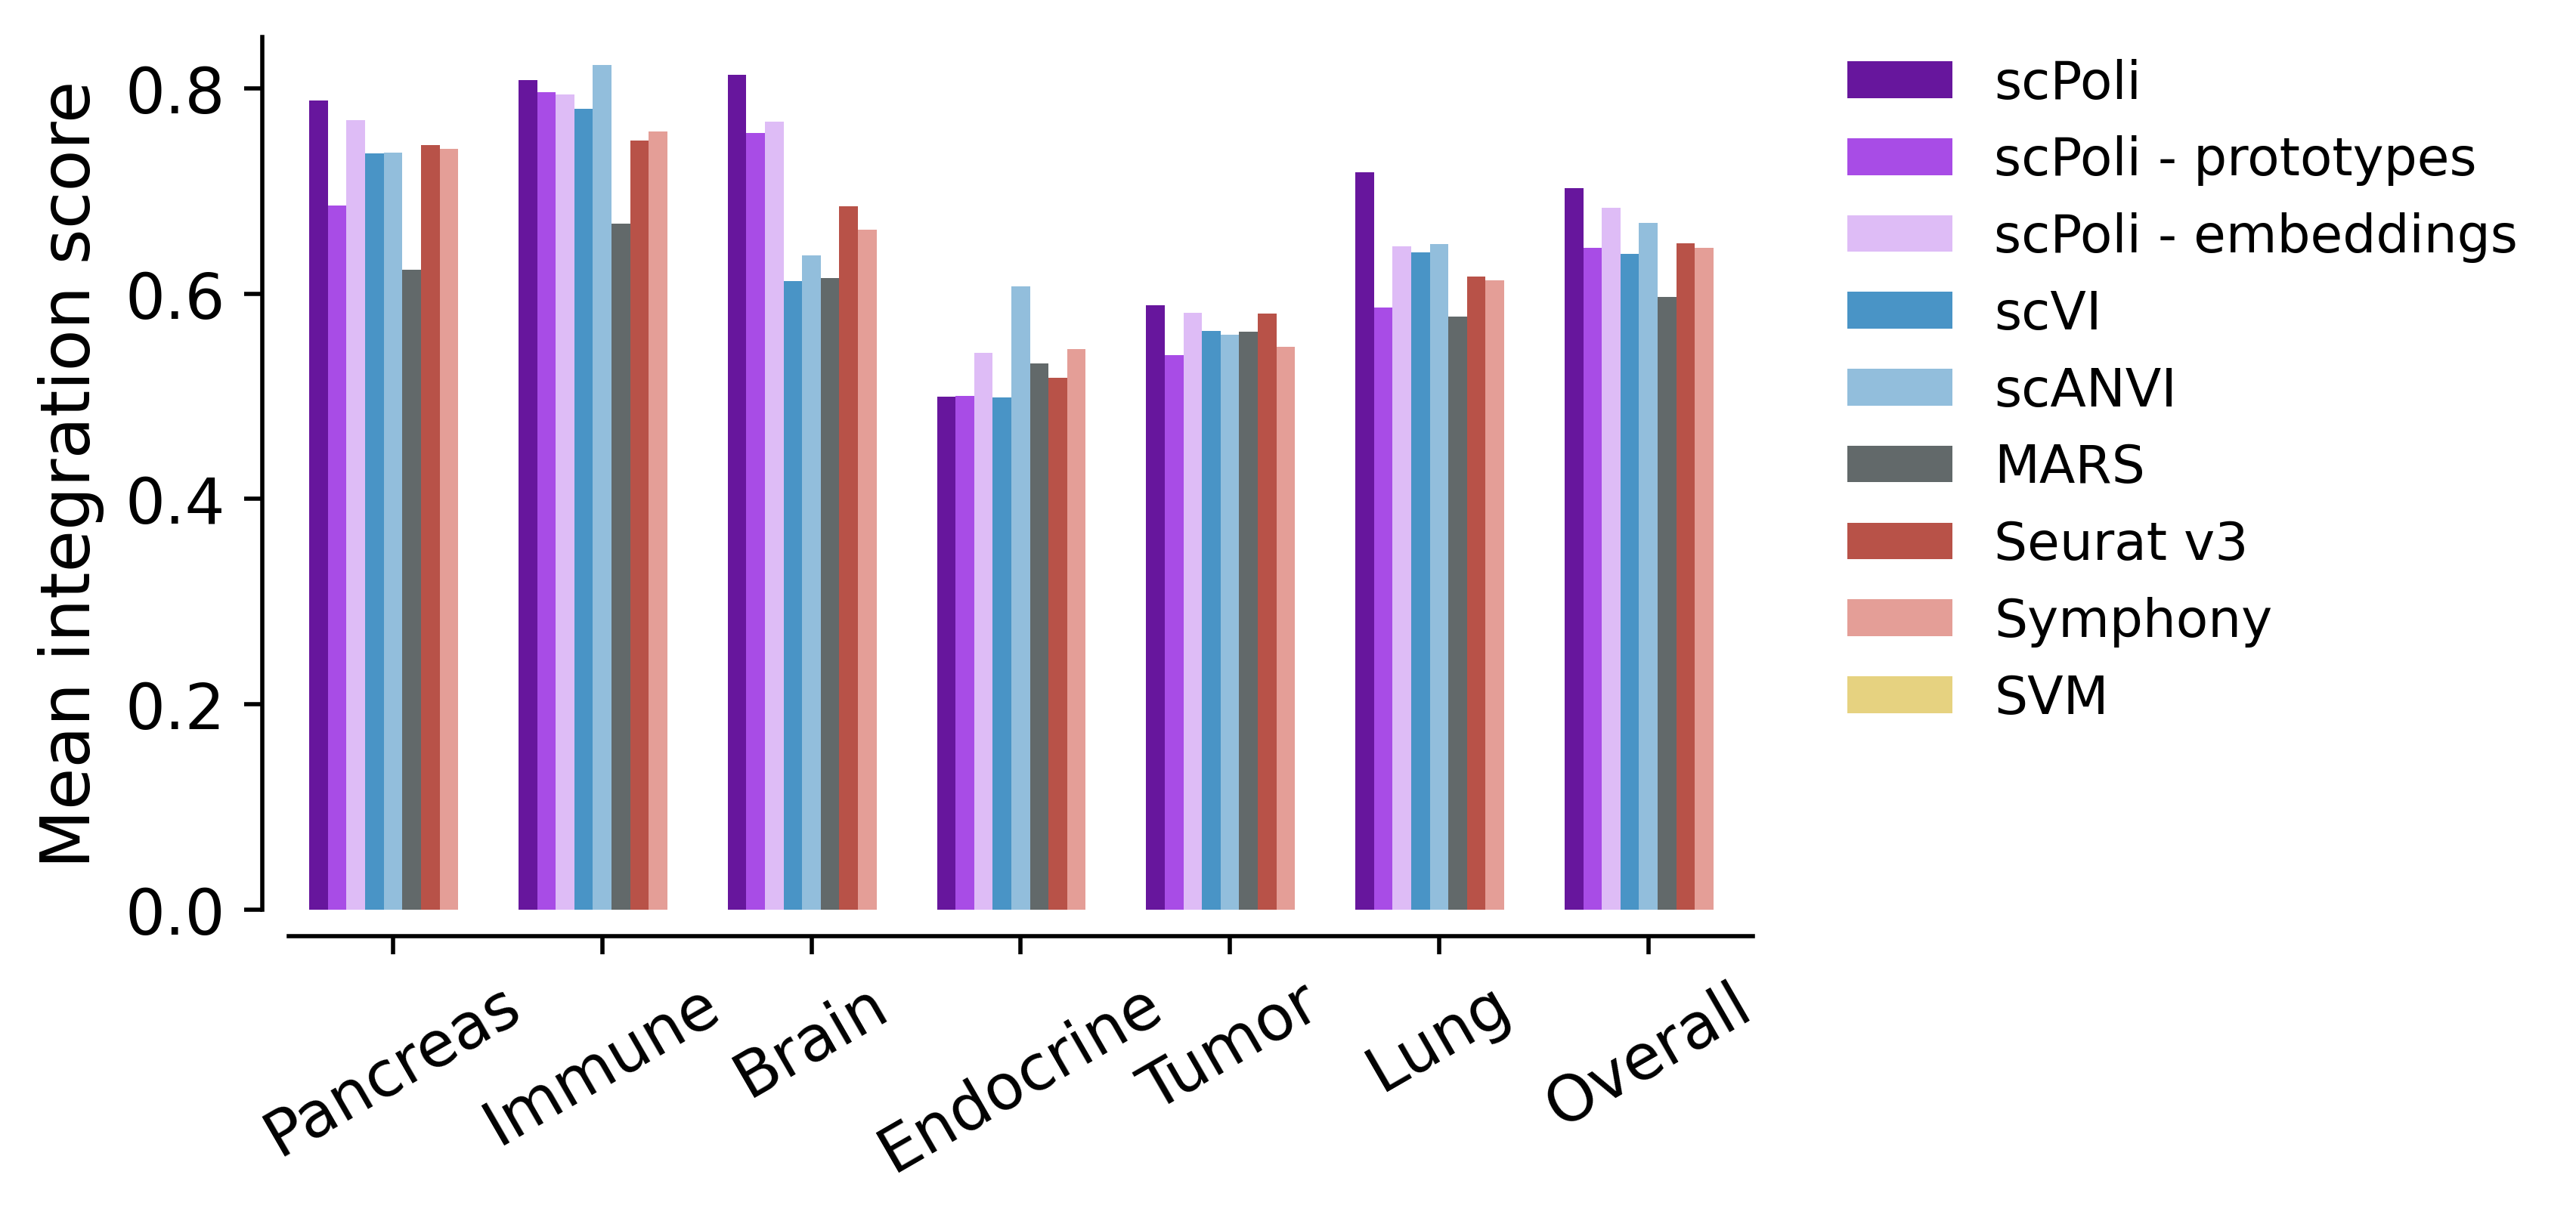

In [98]:
df_plot = results_melt[
    (results_melt['variable'] == 'integration_scores_weighted_mean')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
#ax.set_title('Integration scores mean')
ax.set_ylabel('Mean integration score')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
#ax.get_legend().remove()
ax.set_ylim([0, 0.85])
ax.set_xlabel('')
ax.grid('off')
ax.grid(b=None)
l = ax.get_xticklabels()
l_y = ax.get_yticklabels()
sns.despine(offset=5)
ax.set_xticklabels(l, fontsize=12, rotation=30)
ax.set_yticklabels(l_y, fontsize=12)
fig.savefig('figure2/legend.png', dpi=600, bbox_inches='tight')

/tmp/ipykernel_109736/1605707291.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/tmp/ipykernel_109736/1605707291.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df_plot.groupby('method').mean()
/tmp/ipykernel_109736/1605707291.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot = df_plot.append(mean_df)
/tmp/ipykernel_109736/1605707291.py:29: MatplotlibDeprecationWarning: Th

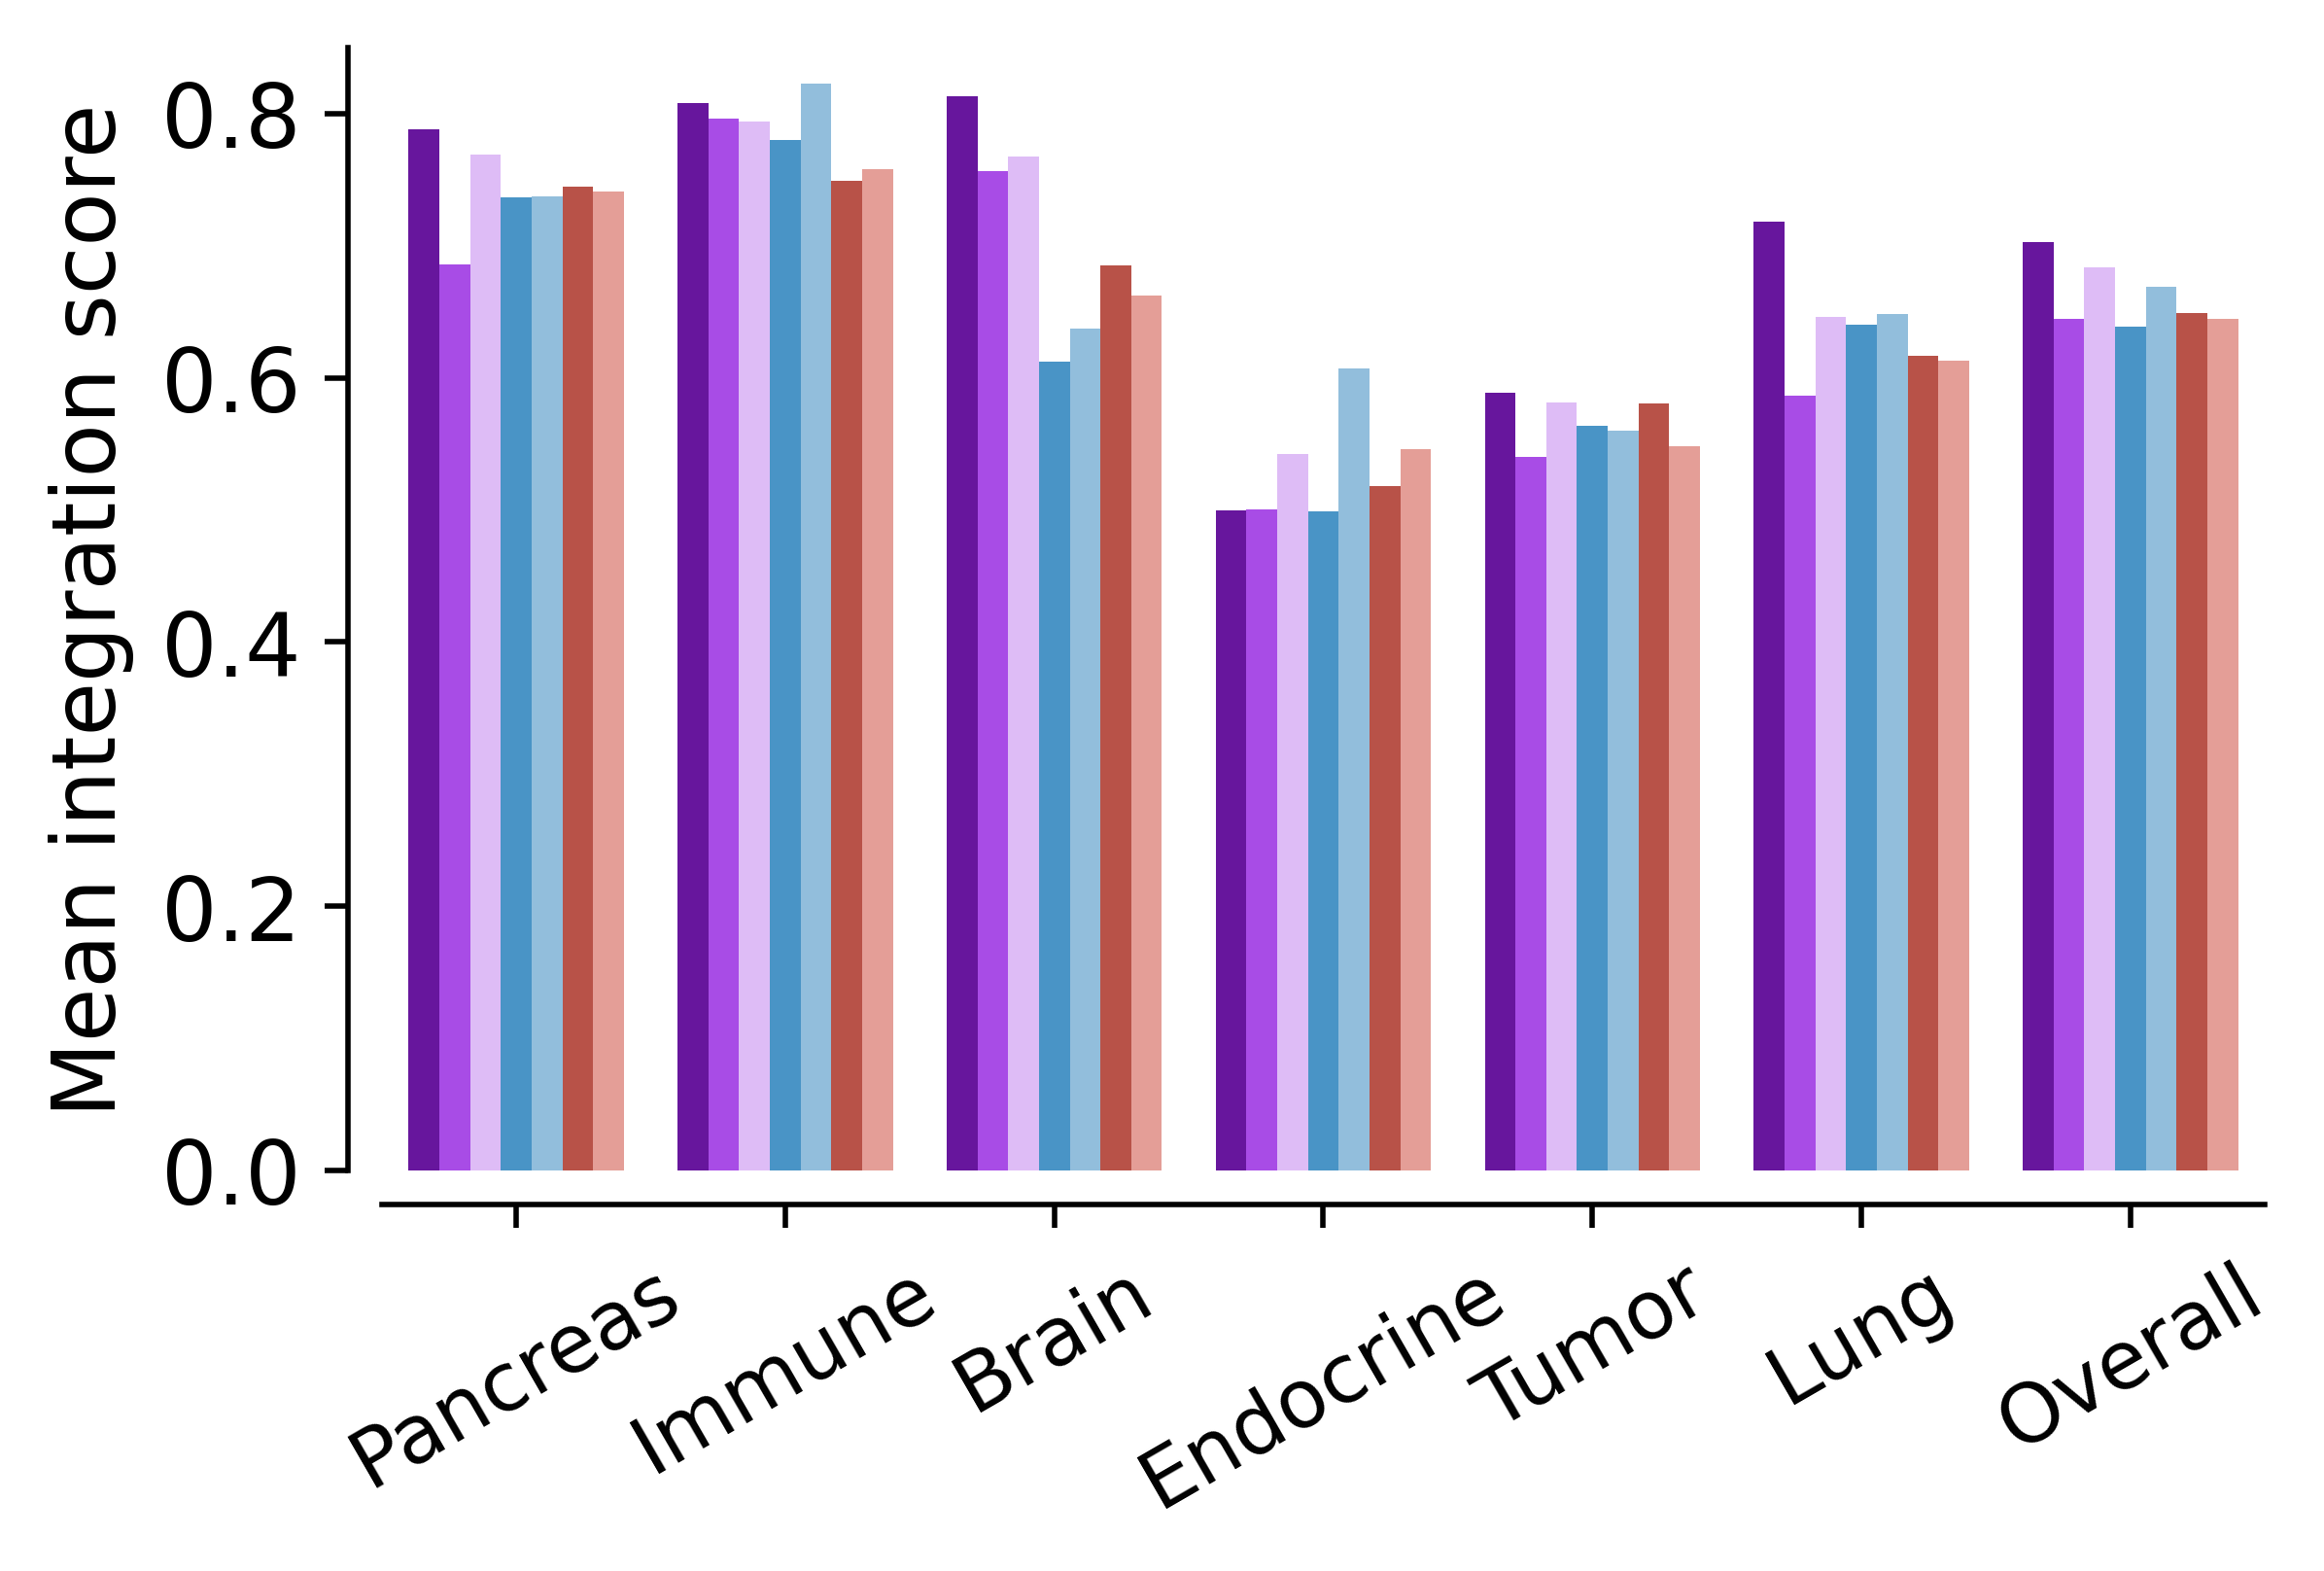

In [99]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
    & (results_melt['variable'] == 'integration_scores_weighted_mean')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
#ax.set_title('Integration scores mean')
ax.set_ylabel('Mean integration score')
ax.set_xlabel('')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.set_ylim([0, 0.85])
ax.grid('off')
ax.grid(b=None)
l = ax.get_xticklabels()
sns.despine(offset=5)
ax.set_xticklabels(l, fontsize=12, rotation=30)
fig.savefig('figure2/benchmark_integration.png', dpi=600, bbox_inches='tight')

In [100]:
mean_df = mean_df.set_index('method')['value']

In [101]:
mean_df

method
scPoli                 0.702784
scPoli - prototypes    0.644432
scPoli - embeddings    0.683541
scVI                   0.638697
scANVI                 0.668920
Seurat v3              0.649152
Symphony               0.644541
Name: value, dtype: float64

In [102]:
(mean_df.loc['scPoli'] - mean_df.loc['scANVI']) / mean_df.loc['scANVI']

0.050624696984192606

In [103]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
    & (results_melt['variable'] == 'bio_conservation_mean')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'value', 'config.data']
mean_df = mean_df.set_index('method')['value']
(mean_df.loc['scPoli'] - mean_df.loc['scANVI']) / mean_df.loc['scANVI']

/tmp/ipykernel_109736/446282373.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/tmp/ipykernel_109736/446282373.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df_plot.groupby('method').mean()


0.07443839278023094

In [104]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby(['method', 'metric_type']).mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'metric_type', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

df_plot

/tmp/ipykernel_109736/511527403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/tmp/ipykernel_109736/511527403.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df_plot.groupby(['method', 'metric_type']).mean()
/tmp/ipykernel_109736/511527403.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot = df_plot.append(mean_df)


,config.data,method,variable,value,metric_type
108,Pancreas,scANVI,result.NMI_cluster/label,0.925007,bio conservation
109,Immune,scANVI,result.NMI_cluster/label,0.886107,bio conservation
110,Brain,scANVI,result.NMI_cluster/label,0.711047,bio conservation
111,Endocrine,scANVI,result.NMI_cluster/label,0.612339,bio conservation
112,Tumor,scANVI,result.NMI_cluster/label,0.474573,bio conservation
...,...,...,...,...,...
9,Overall,scANVI,NaN,0.656341,bio conservation
10,Overall,Seurat v3,NaN,0.708210,batch correction
11,Overall,Seurat v3,NaN,0.609780,bio conservation
12,Overall,Symphony,NaN,0.728629,batch correction


/tmp/ipykernel_109736/2802505017.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/tmp/ipykernel_109736/2802505017.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df_plot.groupby(['method', 'metric_type']).mean()
/tmp/ipykernel_109736/2802505017.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot = df_plot.append(mean_df)
/tmp/ipykernel_109736/2802505017.py:28: MatplotlibDepre

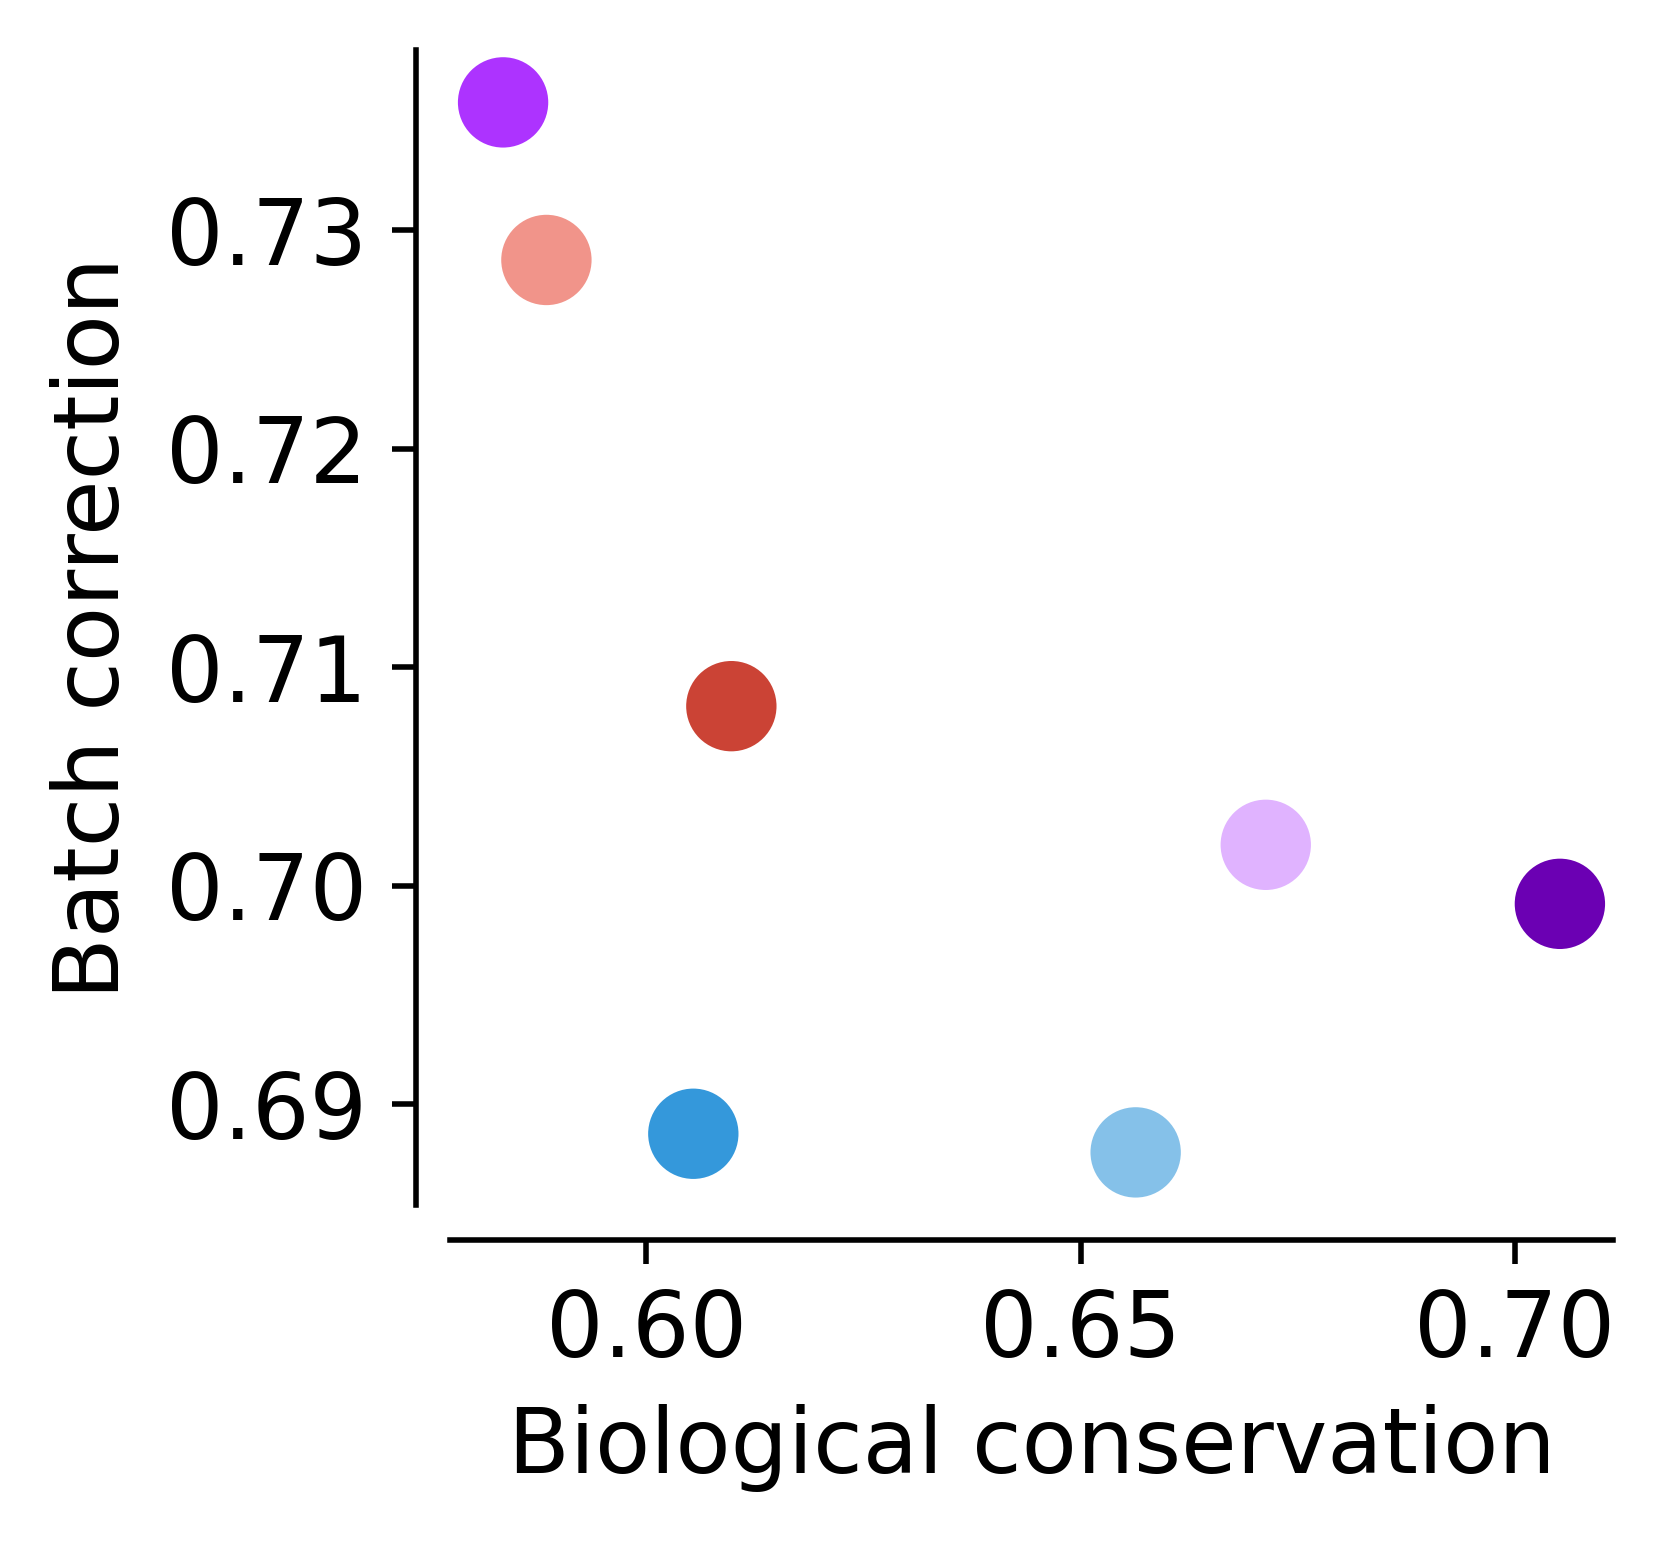

In [105]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby(['method', 'metric_type']).mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'metric_type', 'value', 'config.data']
df_plot = df_plot.append(mean_df)
d = df_plot[df_plot['config.data'] == 'Overall'].set_index(['method', 'metric_type']).unstack()['value']

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(
    x=d['bio conservation'], 
    y=d['batch correction'],
    palette=palette_dict,
    hue=d.index, 
    ax=ax,
    s=200,
)
#ax.set_title('Integration performance')
ax.set_ylabel('Batch correction')
ax.set_xlabel('Biological conservation')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.grid('off')
ax.grid(b=None)
#l = ax.get_xticklabels()
sns.despine(offset=5)
#ax.set_xticklabels(l, fontsize=12, rotation=30)
fig.savefig('figure2/benchmark_biobatch.png', dpi=600, bbox_inches='tight')

/tmp/ipykernel_109736/3354958111.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/tmp/ipykernel_109736/3354958111.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df_plot.groupby('method').mean()
/tmp/ipykernel_109736/3354958111.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot = df_plot.append(mean_df)
/tmp/ipykernel_109736/3354958111.py:29: MatplotlibDeprecationWarning: Th

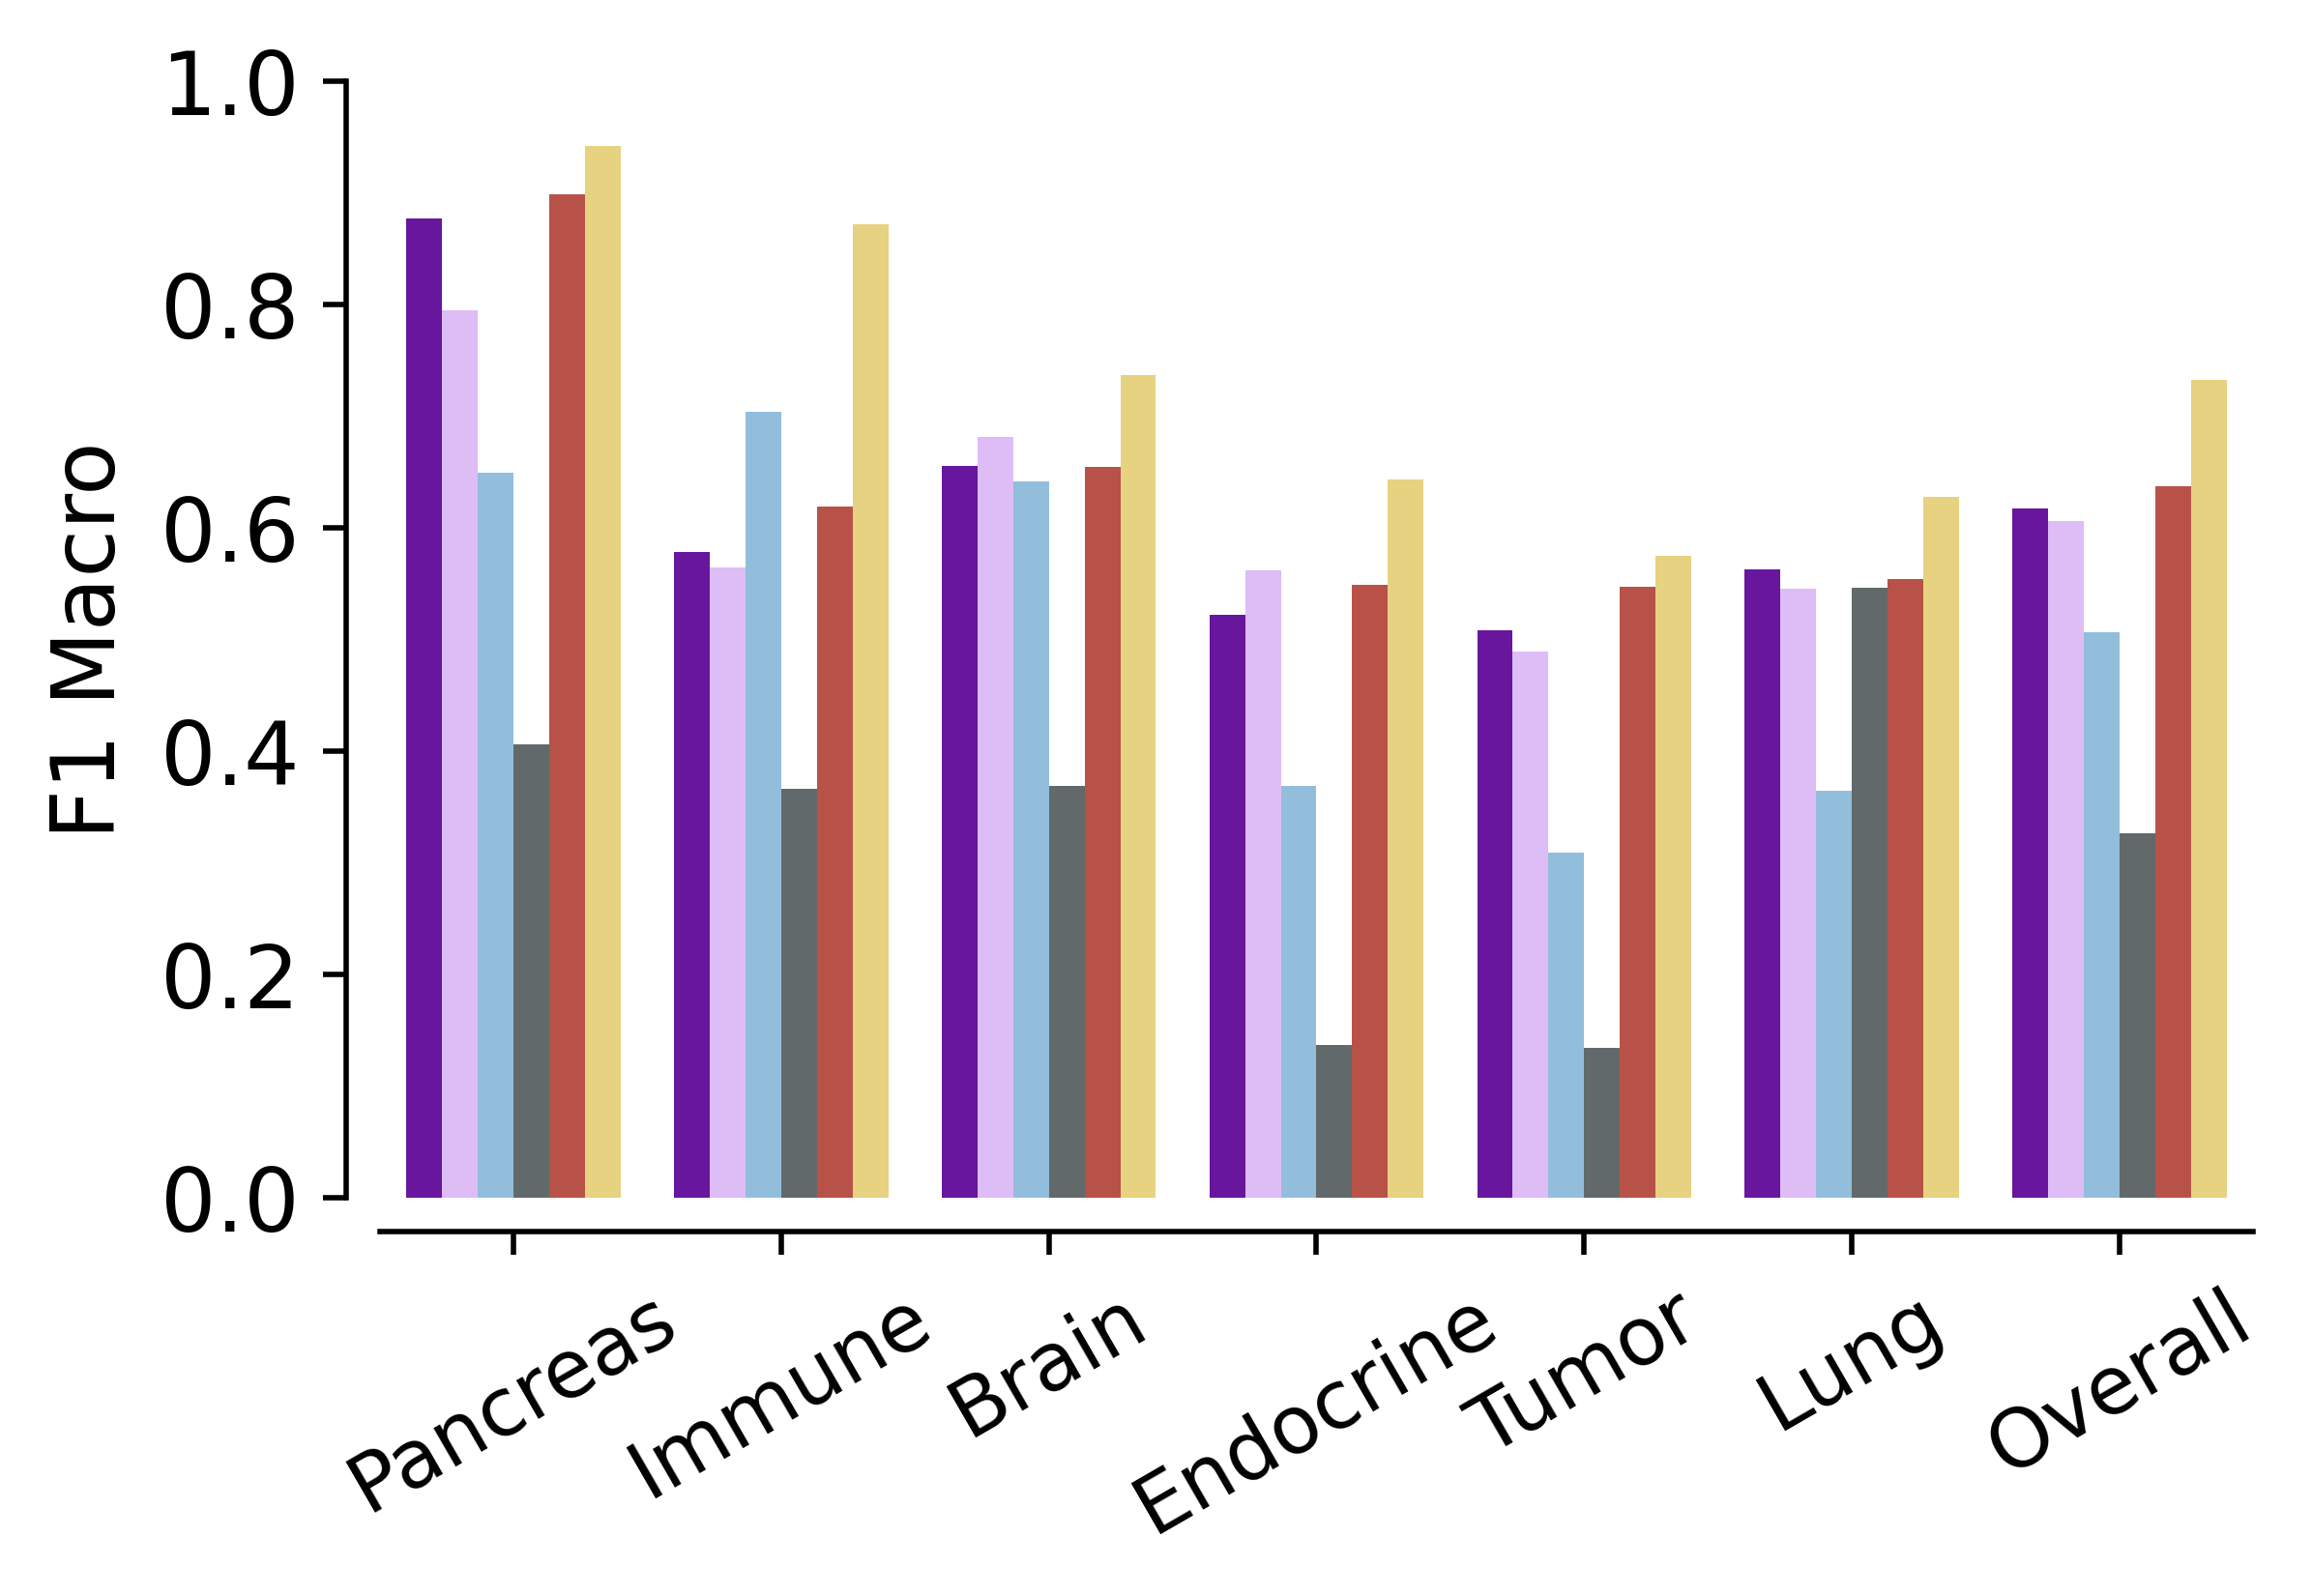

In [111]:
df_plot = results_melt[
    (results_melt['method'].isin(classification_methods))
    & (results_melt['variable'] == 'result.f1-score-macro')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_ylabel('F1 Macro')
#ax.set_ylabel('Value')
ax.set_xlabel('')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
l = ax.get_xticklabels()
sns.despine(offset=5)
ax.set_xticklabels(l, fontsize=12, rotation=30)
fig.savefig('figure2/benchmark_f1macro.png', dpi=600, bbox_inches='tight')

/tmp/ipykernel_109736/2510190429.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/tmp/ipykernel_109736/2510190429.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df_plot.groupby('method').mean()
/tmp/ipykernel_109736/2510190429.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot = df_plot.append(mean_df)
/tmp/ipykernel_109736/2510190429.py:29: MatplotlibDeprecationWarning: Th

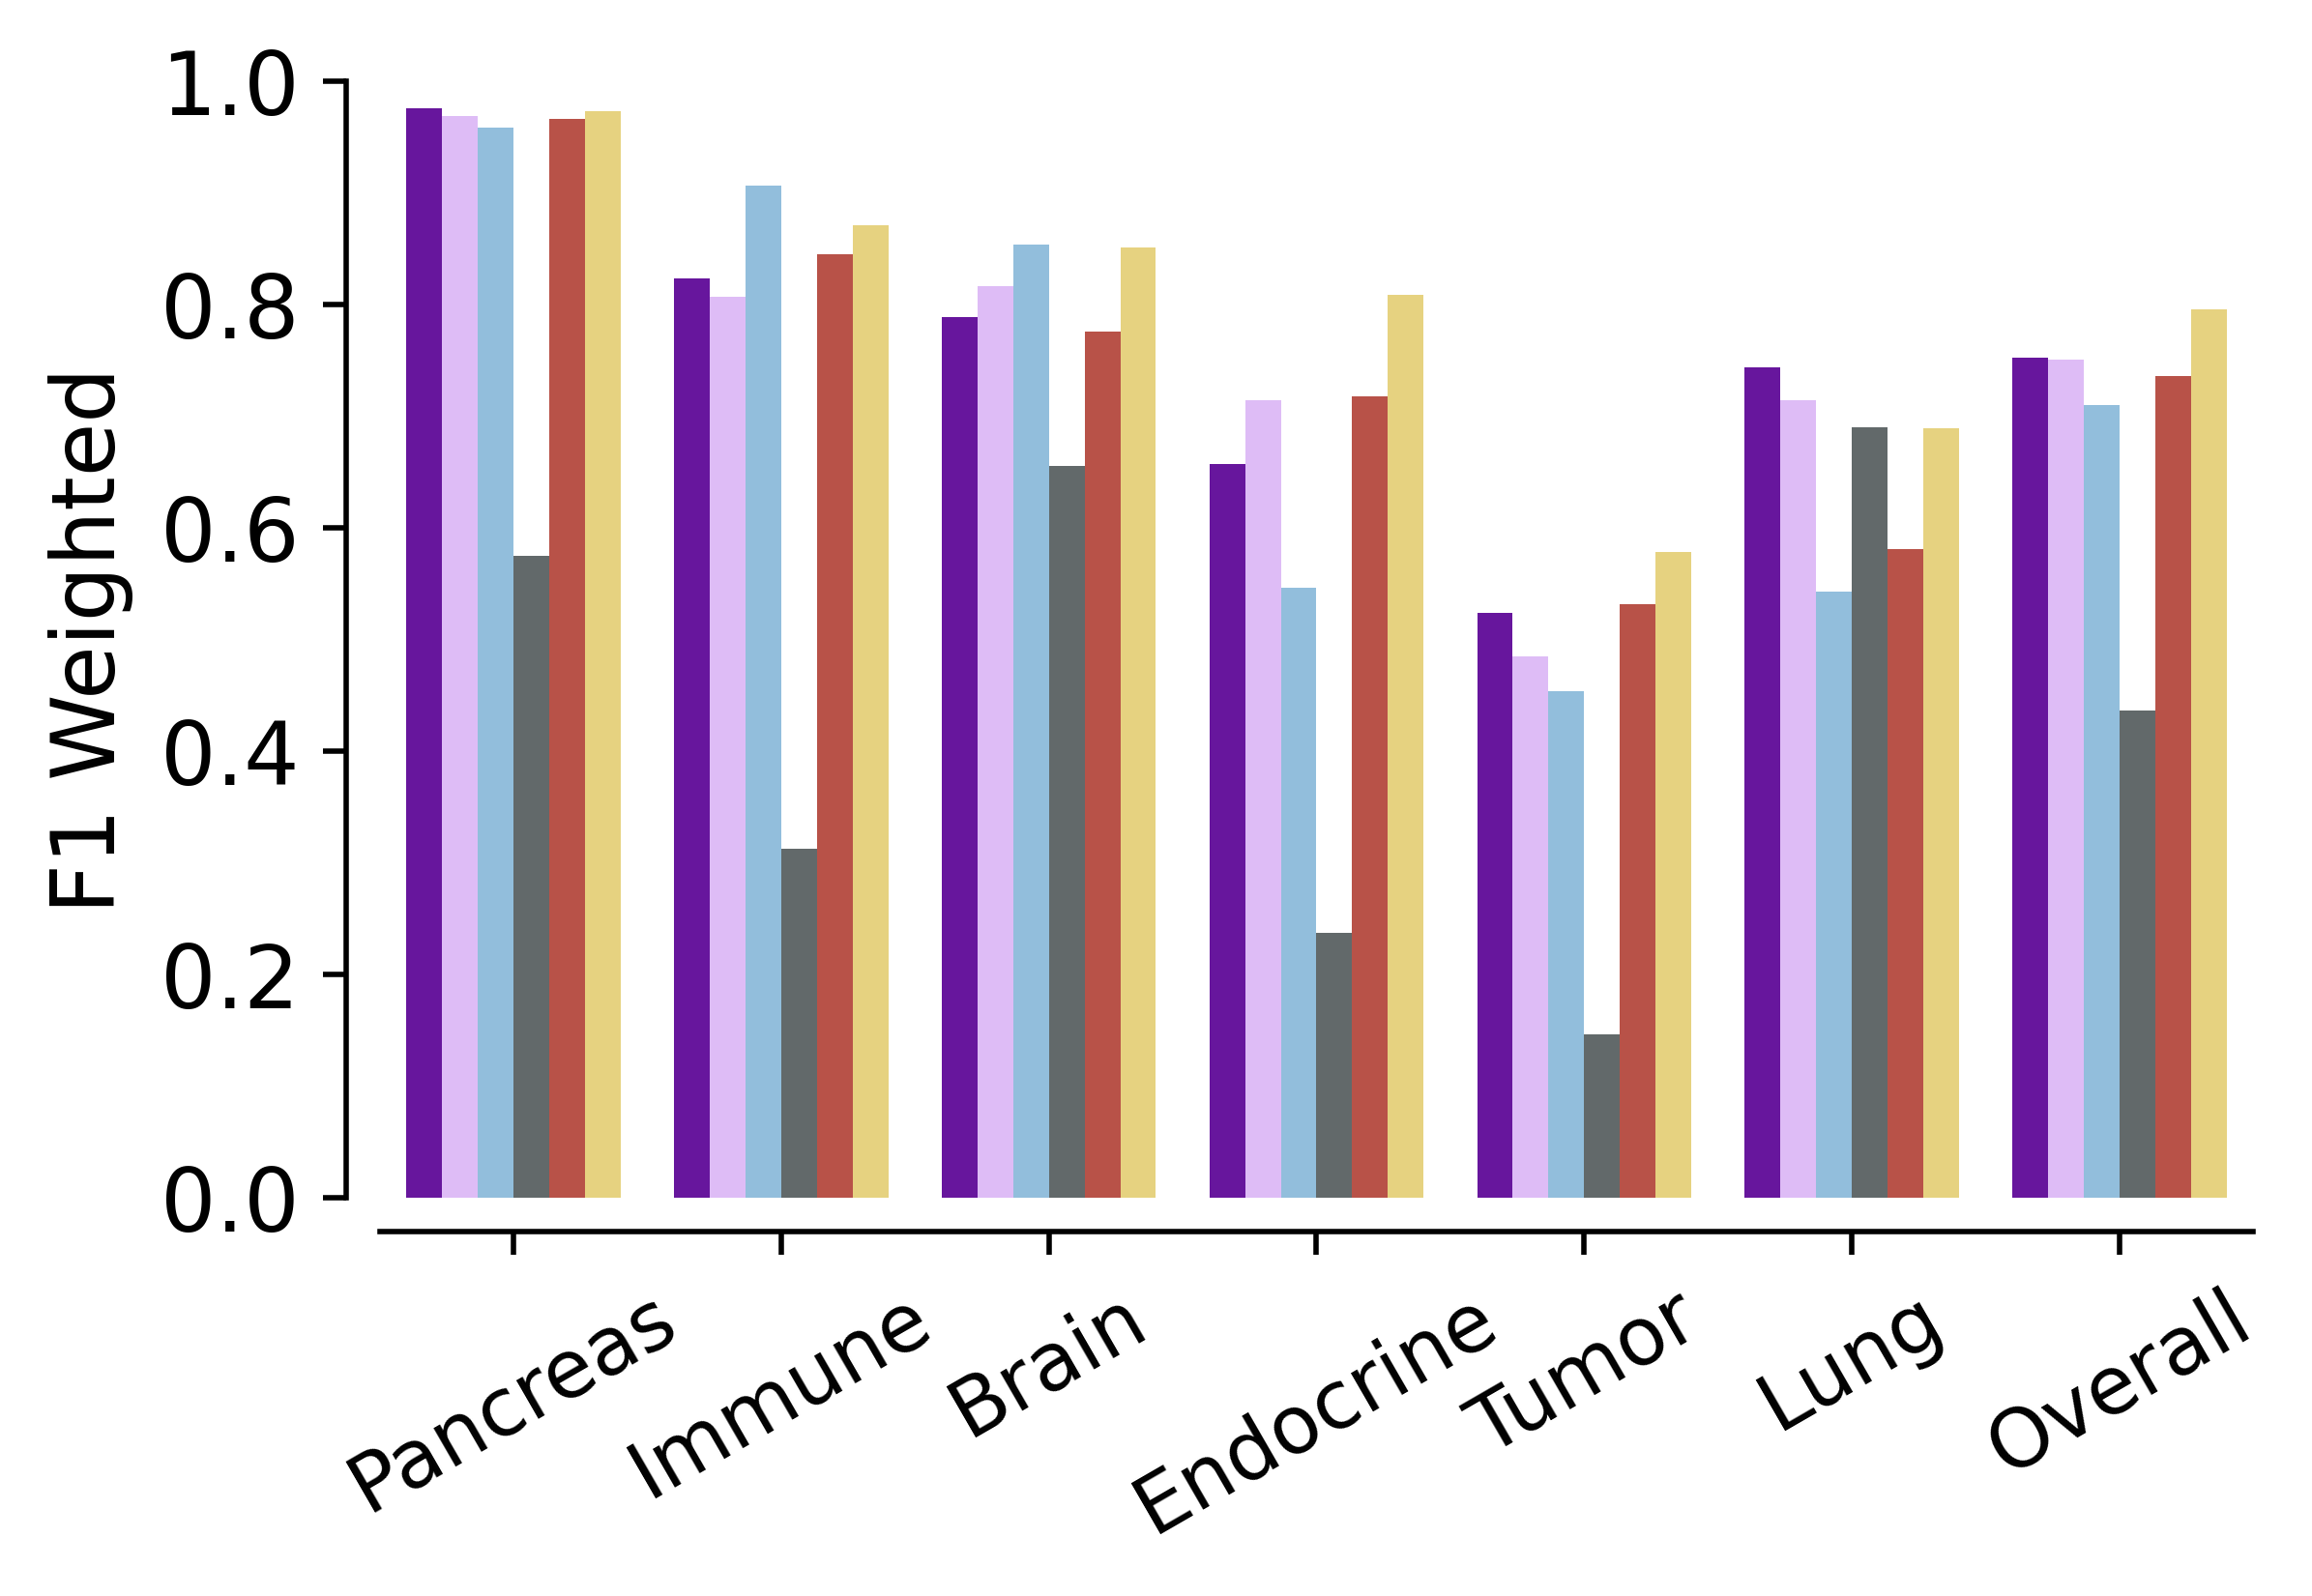

In [112]:
df_plot = results_melt[
    (results_melt['method'].isin(classification_methods))
    & (results_melt['variable'] == 'result.f1-score-weighted')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'Overall'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_ylabel('F1 Weighted')
#ax.set_ylabel('Value')
ax.set_xlabel('')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
l = ax.get_xticklabels()
sns.despine(offset=5)
ax.set_xticklabels(l, fontsize=12, rotation=30)
fig.savefig('figure2/benchmark_f1weighted.png', dpi=600, bbox_inches='tight')

/tmp/ipykernel_109736/1824907334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/tmp/ipykernel_109736/1824907334.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df_plot.groupby(['method', 'variable']).mean()
/tmp/ipykernel_109736/1824907334.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


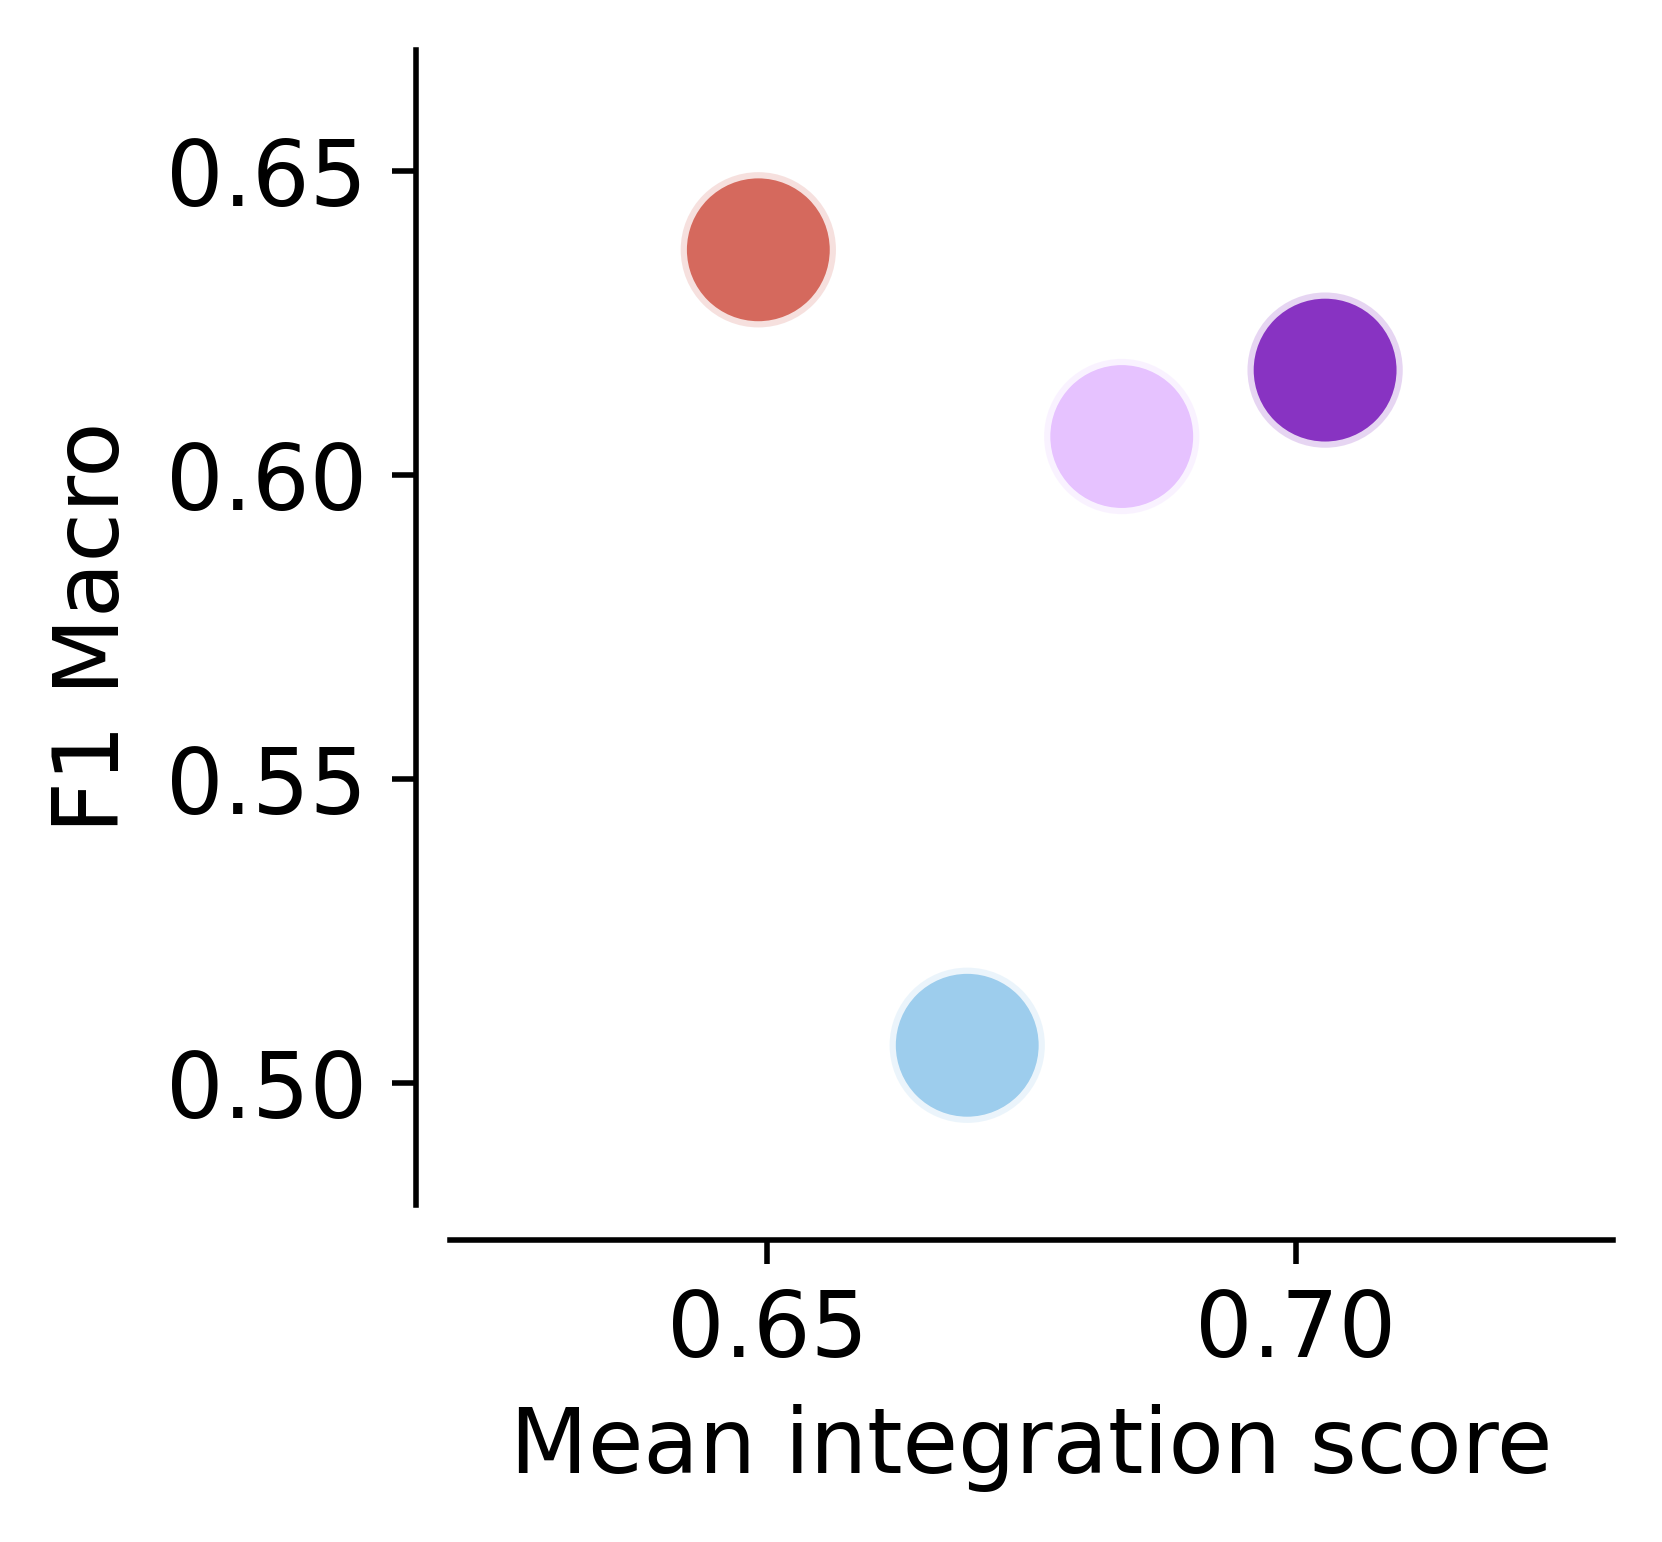

In [108]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby(['method', 'variable']).mean()
mean_df = pd.pivot_table(mean_df, index='method', columns='variable', values='value')
mean_df = mean_df.reset_index()

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(
    x=mean_df['integration_scores_weighted_mean'].values, 
    y=mean_df['result.f1-score-macro'].values,
    palette=palette_dict,
    hue=mean_df.method, 
    ax=ax,
    s=500,
    alpha=0.8,
)
#ax.set_title('Integration performance')
ax.set_ylabel('F1 Macro')
ax.set_xlabel('Mean integration score')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.set_xlim([0.62, 0.73])
ax.set_ylim([0.48, 0.67])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
#fig.savefig('figure2/benchmark_biobatch.png', dpi=600, bbox_inches='tight')

/tmp/ipykernel_109736/790764498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/tmp/ipykernel_109736/790764498.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df_plot.groupby(['method', 'variable']).mean()
/tmp/ipykernel_109736/790764498.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


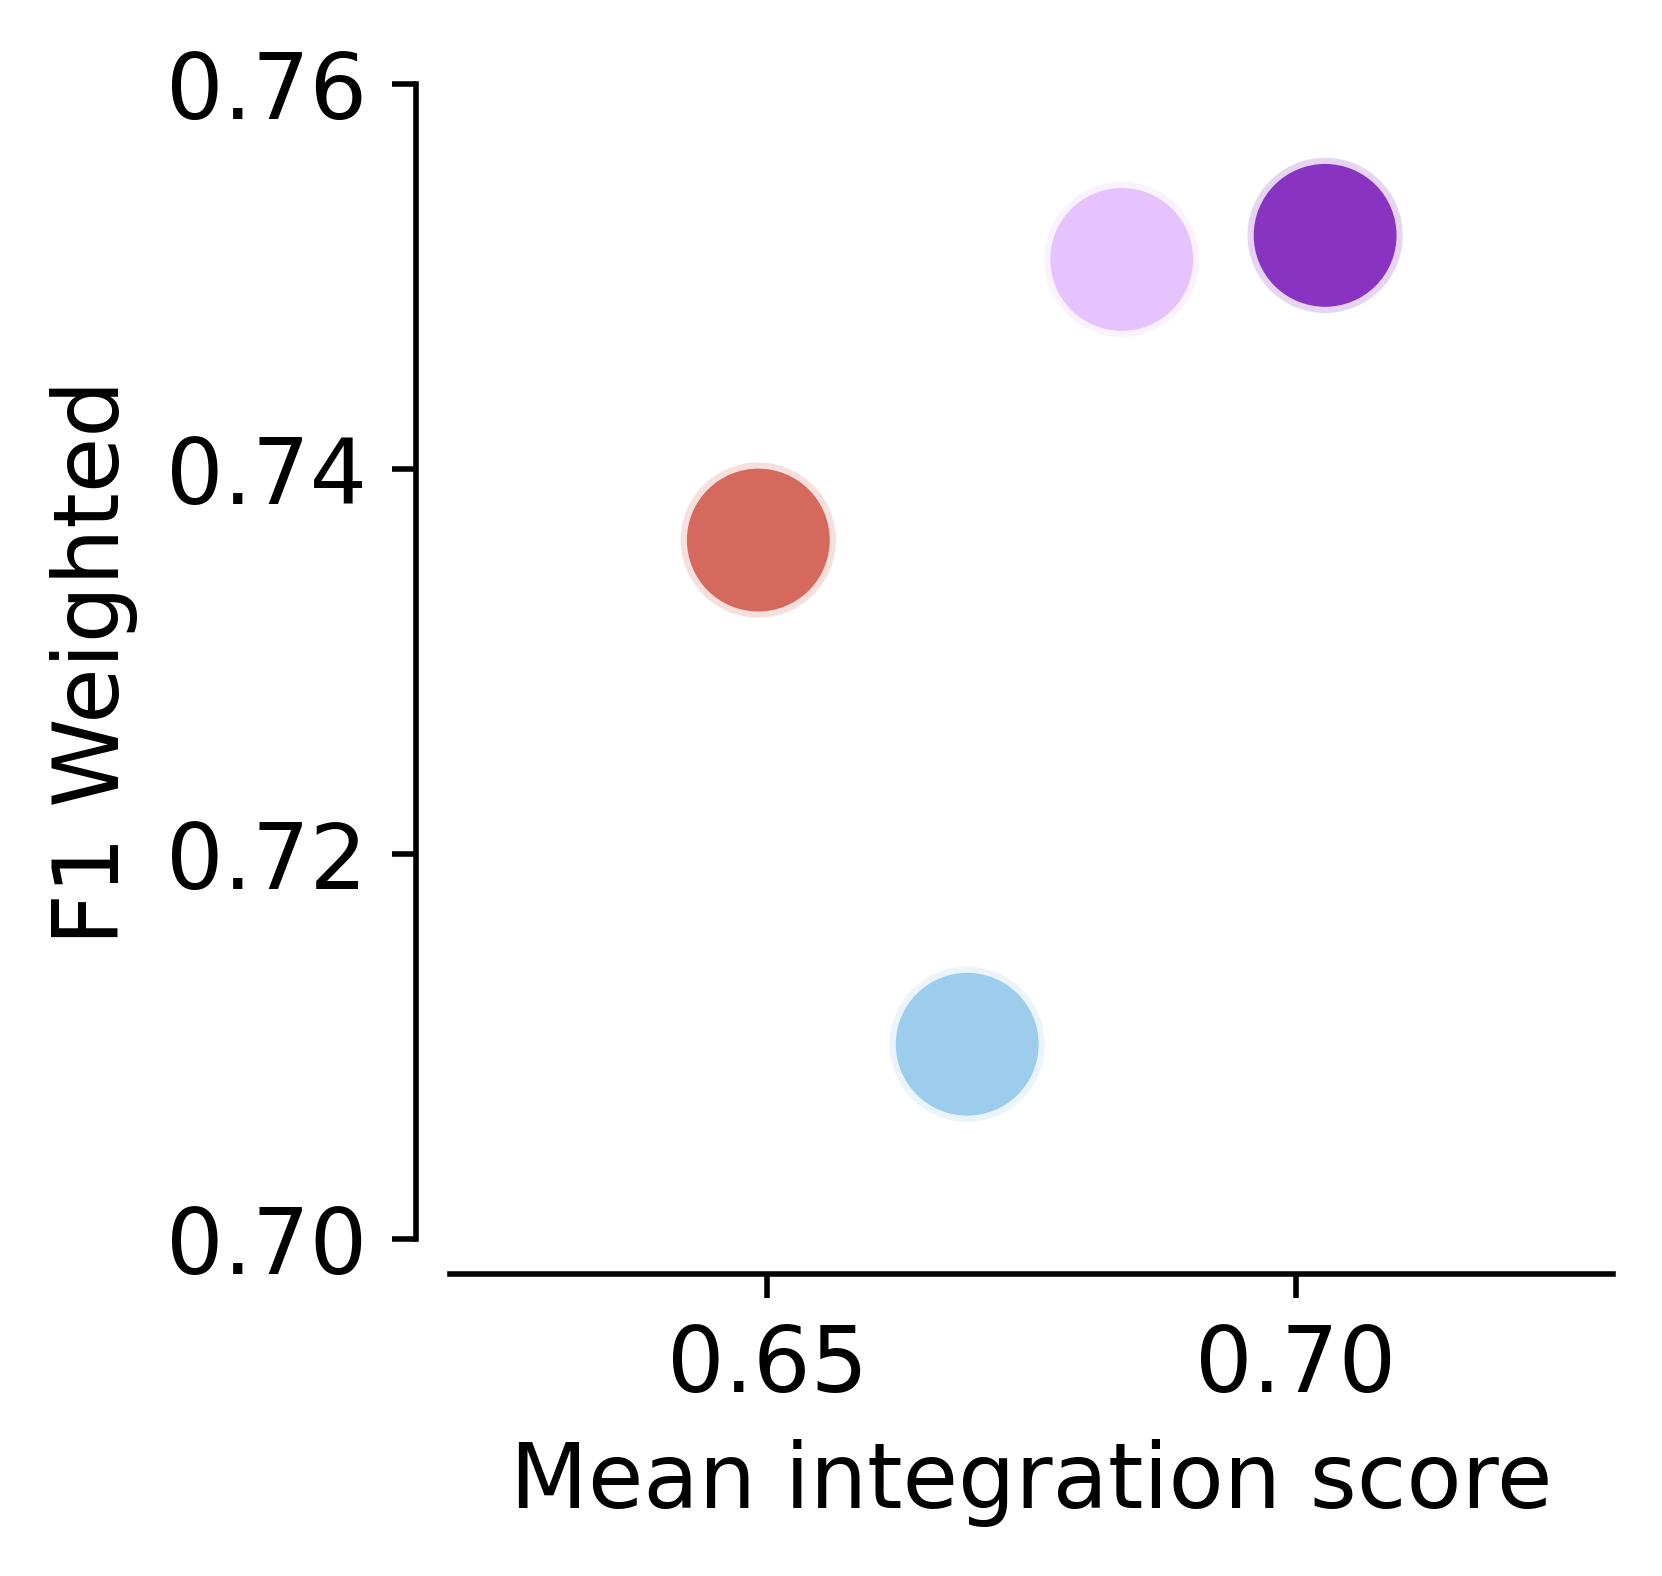

In [109]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby(['method', 'variable']).mean()
mean_df = pd.pivot_table(mean_df, index='method', columns='variable', values='value')
mean_df = mean_df.reset_index()

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(
    x=mean_df['integration_scores_weighted_mean'].values, 
    y=mean_df['result.f1-score-weighted'].values,
    palette=palette_dict,
    hue=mean_df.method, 
    ax=ax,
    s=500,
    alpha=0.8,
)
#ax.set_title('Integration performance')
ax.set_ylabel('F1 Weighted')
ax.set_xlabel('Mean integration score')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.get_legend().remove()
ax.set_xlim([0.62, 0.73])
ax.set_ylim([0.7, 0.76])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
#fig.savefig('figure2/benchmark_biobatch.png', dpi=600, bbox_inches='tight')

In [110]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
ax=ax.flatten()
for i, var in enumerate(results_melt['variable'].unique()[:10]):
    df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
        & (results_melt['variable'] == var)
    ]
    df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

    mean_df = df_plot.groupby('method').mean()
    mean_df = mean_df.reset_index()
    mean_df['index'] = 'avg'
    mean_df.columns = ['method', 'value', 'config.data']
    df_plot = df_plot.append(mean_df)

    #fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.barplot(
        x='config.data',
        y='value',
        hue='method',
        data=df_plot,
        palette=palette_dict,
        ax=ax[i]
    )
    ax[i].set_title(var.split('.')[-1])
    ax[i].set_ylabel('Score')
    ax[i].set_xlabel('Dataset')
    if i == 1:
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    else:
        ax[i].get_legend().remove()
    ax[i].set_ylim([0, 0.85])
    ax[i].grid('off')
    ax[i].grid(b=None)
    sns.despine(offset=5)
fig.tight_layout()
    #fig.savefig('figure2/benchmark_integration.png', dpi=600, bbox_inches='tight')

/tmp/ipykernel_109736/3006259922.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/tmp/ipykernel_109736/3006259922.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df_plot.groupby('method').mean()
/tmp/ipykernel_109736/3006259922.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot = df_plot.append(mean_df)
/tmp/ipykernel_109736/3006259922.py:34: MatplotlibDeprecationWarning: T